[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, grad,jit,vmap
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import JaxSSO as sso #Sensitivity analysis solver
import jax
jax.config.update("jax_enable_x64", True)

# Define the objective function and the gradient of the objective

*   Import the geometry, mesh
*   Build the FEA model
*   Build the SSO model



Import the data needed

In [2]:
#Import the geometry, mesh and fixed node info
local_path = 'https://raw.githubusercontent.com/GaoyuanWu/JaxSSO/main/data/Mannheim_Multihalle/' #path of the file
df = pd.read_csv(local_path + 'Mesh.csv') #Connectivity matrix
cnct = df.to_numpy() #convert to numpy array
df2 = pd.read_csv(local_path + 'Coordinate.csv') #Coordinate
crd = df2.to_numpy() #convert to numpy array
df3 = pd.read_csv(local_path + 'fixed_nodes.csv') #Connectivity matrix
fixed_nodes = df3.to_numpy().reshape(-1) #convert to numpy array

#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

Configure the design variables and non-design variables

In [3]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)
    z_nodes[i] = 0.5#np.random.rand()
  else:
    z_nodes[i] = 0
fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]


The initial structure, visualization

<ipython-input-4-3e93a0514e5c>:18: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-4-3e93a0514e5c>:19: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-4-3e93a0514e5c>:20: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


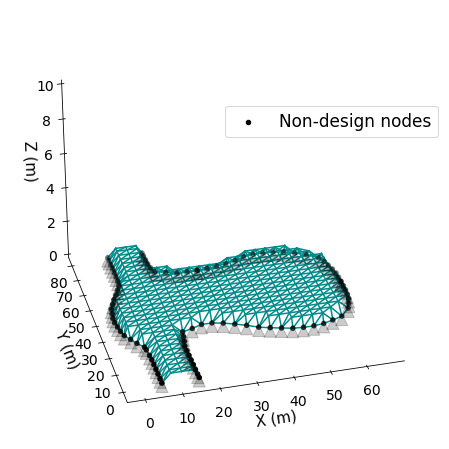

In [4]:

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

Define the objective function (with its gradient).

Create some lists/arrays to store the intermediate results.

In [5]:
params_store = [] #store parameters
f_store = [] #store the functional value 
sparse = True #Store values in sparse matrix

In [6]:
def objective(x):

    params_store.append(x) #store params at each step
    z_nodes[design_nodes] = x #update the nodal coordiante

    #Sectional properties-> 600x400 rectangle
    h = 0.6 #height
    b = 0.4 #width
    E = 37900 * 10**6 #Young's modulus (pa)
    G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
    Iy = b*h**3/12 #Moement of inertia in m^4
    Iz = h*b**3/12 #Same, about z axis
    J = Iy + Iz	#Polar moment of inertia
    A = b*h #Area

    #Nodal loads
    load = -100000/1000
    f = np.zeros(n_node*6)
    f[design_nodes*6+2] = load # nodal load in -z

    ################
    #  SSO MODEL   #
    ################
    #Build the model
    sens_model = sso.Model_Sens.Model_Sens() #model for sensitivity analysis

    #Adding nodes and boundary conditions
    for i in range(n_node):
        
        sens_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])
        if i not in design_nodes:
            sens_model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow

    #Adding elements
    for i in range(n_ele):
        i_node = cnct[i,0]
        j_node = cnct[i,1]
        sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 
    
    #Adding load
    sens_model.add_nodal_load(f)

    #Conduct FEA
    sens_model.solve()
    u_disp = sens_model.u #global displacement
    C = 0.5*f@u_disp #compliance of the system
    f_store.append(C) #store the compliance 
    

    ##################
    #  Gradient      #
    ##################
    #Get the sensitivity using SSO
    sens = sens_model.Sens_C_Coord(u_disp)
    z_dof_index = design_nodes*3+2 #index indicating the z-dof
    sens_params = sens[z_dof_index] #storing the sensitivity of obj. wrt design parameters
    return C,sens_params

# Perform the optimization with gradient descent

In [7]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
opt = sso.Optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(150) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalize the gradients
x_opt = opt.optimize(x_ini)

Step 0, objective = -0.8719971978915063
Step 1, objective = 3.034226272375007
Step 2, objective = 2.7781235861691442
Step 3, objective = 2.5375266712376865
Step 4, objective = 2.3117023402342545
Step 5, objective = 2.09102735875588
Step 6, objective = 1.8558754383963203
Step 7, objective = 1.6189745411194343
Step 8, objective = 1.4397423994924448
Step 9, objective = 1.2812452626814879
Step 10, objective = 1.1243391825531308
Step 11, objective = 0.9894923733134651
Step 12, objective = 0.886994402048748
Step 13, objective = 0.8187954957282486
Step 14, objective = 0.7709875965078017
Step 15, objective = 0.7296560138611995
Step 16, objective = 0.6856361857383172
Step 17, objective = 0.6302555857424558
Step 18, objective = 0.5940772966530092
Step 19, objective = 0.5638494732261834
Step 20, objective = 0.5321374660713778
Step 21, objective = 0.4893292062159528
Step 22, objective = 0.4412775548671256
Step 23, objective = 0.3998469634928342
Step 24, objective = 0.3624595959877447
Step 25, obje

# Draw the final structure

<ipython-input-8-9eabd8297004>:23: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-8-9eabd8297004>:24: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-8-9eabd8297004>:25: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


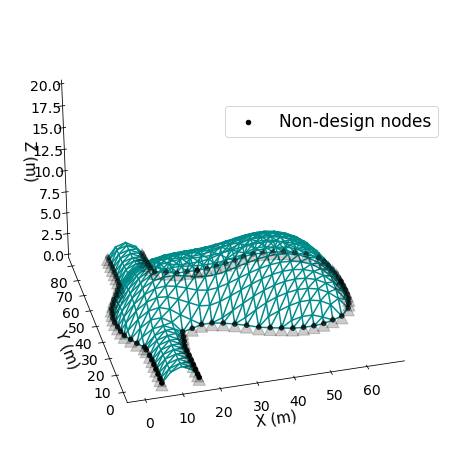

In [8]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,20)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()